# p53 Data

In [4]:
import torch
import numpy as np
import pandas as pd

from torch.utils.data import Dataset
from os import path
from abc import ABC


f64 = np.float64


class LFMDataset(Dataset):

    def __getitem__(self, index):
        return self.data[index]

    @property
    def num_outputs(self):
        """The number of LFM outputs."""
        return self._num_outputs

    @num_outputs.setter
    def num_outputs(self, value):
        self._num_outputs = value

    @property
    def data(self):
        """
        List of data points, each a tuple(a, b).
        For time-series, a and b are 1-D.
        For spatiotemporal series, a is (2, T) corresponding to a row for time and space, and b is 1-D.
        """
        return self._data

    @data.setter
    def data(self, value):
        self._data = value

    def __len__(self):
        return len(self.data)
    

class TranscriptomicTimeSeries(LFMDataset, ABC):
    def __init__(self):
        self._m_observed = None
        self._t_observed = None

    @property
    def t_observed(self):
        return self._t_observed

    @t_observed.setter
    def t_observed(self, value):
        self._t_observed = value

    @property
    def m_observed(self):
        """m_observed has shape (replicates, genes, times)"""
        return self._m_observed

    @m_observed.setter
    def m_observed(self, value):
        self._m_observed = value


class P53Data(TranscriptomicTimeSeries):
    def __init__(self, replicate=None, data_dir='../data/'):
        super().__init__()
        m_observed, f_observed, σ2_m_pre, σ2_f_pre, t = load_barenco_puma(data_dir)

        m_df, m_observed = m_observed  # (replicates, genes, times)
        self.gene_names = m_df.index
        num_times = m_observed.shape[2]
        num_genes = m_observed.shape[1]
        num_replicates = m_observed.shape[0]
        self.num_outputs = num_genes

        # f_df, f_observed = f_observed
        m_observed = torch.tensor(m_observed)
        self.t_observed = torch.linspace(f64(0), f64(12), 7)
        self.m_observed = m_observed
        self.f_observed = torch.tensor([0.7116,0.7008,1.5933,0.7507,0.2346,0.3617,0.0673]).view(1, 1, 7)
        self.f_observed = torch.tensor([0.1845,1.1785,1.6160,0.8156,0.6862,-0.1828, 0.5131]).view(1, 1, 7)
        self.ups_f_observed = torch.tensor([ 0.1654,  0.2417,  0.3680,  0.5769,  0.8910,  1.2961,  1.7179,  2.0301,
         2.1055,  1.8885,  1.4407,  0.9265,  0.5467,  0.4493,  0.6573,  1.0511,
         1.4218,  1.5684,  1.3876,  0.9156,  0.3090, -0.2256, -0.5218, -0.5191,
        -0.2726,  0.0860,  0.4121,  0.6056,  0.6397,  0.5517])
        self.ups_m_observed = torch.tensor([
            [ 0.3320,  0.0215,  0.0643,  0.0200,  0.2439],
            [ 0.3930,  0.0870,  0.1319,  0.0946,  0.3119],
            [ 0.4726,  0.1710,  0.2184,  0.1799,  0.3989],
            [ 0.5886,  0.2926,  0.3435,  0.2975,  0.5247],
            [ 0.7662,  0.4779,  0.5343,  0.4745,  0.7165],
            [ 1.0297,  0.7522,  0.8165,  0.7324,  1.0003],
            [ 1.3845,  1.1195,  1.1942,  1.0670,  1.3800],
            [ 1.8027,  1.5484,  1.6352,  1.4351,  1.8230],
            [ 2.2269,  1.9766,  2.0751,  1.7660,  2.2647],
            [ 2.5875,  2.3304,  2.4380,  1.9863,  2.6287],
            [ 2.8234,  2.5466,  2.6588,  2.0439,  2.8495],
            [ 2.8991,  2.5906,  2.7022,  1.9238,  2.8917],
            [ 2.8242,  2.4765,  2.5830,  1.6655,  2.7703],
            [ 2.6636,  2.2771,  2.3761,  1.3663,  2.5610],
            [ 2.5173,  2.1008,  2.1935,  1.1477,  2.3765],
            [ 2.4731,  2.0404,  2.1307,  1.0952,  2.3129],
            [ 2.5574,  2.1206,  2.2130,  1.2074,  2.3954],
            [ 2.7229,  2.2873,  2.3844,  1.3978,  2.5677],
            [ 2.8762,  2.4384,  2.5395,  1.5417,  2.7234],
            [ 2.9200,  2.4701,  2.5715,  1.5321,  2.7550],
            [ 2.7960,  2.3228,  2.4191,  1.3264,  2.6011],
            [ 2.5121,  2.0090,  2.0952,  0.9666,  2.2748],
            [ 2.1368,  1.6051,  1.6790,  0.5574,  1.8559],
            [ 1.7647,  1.2137,  1.2763,  0.2150,  1.4509],
            [ 1.4744,  0.9177,  0.9722,  0.0158,  1.1455],
            [ 1.3047,  0.7557,  0.8064, -0.0219,  0.9796],
            [ 1.2526,  0.7211,  0.7719,  0.0694,  0.9458],
            [ 1.2842,  0.7743,  0.8278,  0.2286,  1.0029],
            [ 1.3540,  0.8650,  0.9222,  0.3933,  1.0986],
            [ 1.4224,  0.9504,  1.0107,  0.5194,  1.1882]]).t()

        self.ups_t_observed = t_predict = torch.linspace(0, 12, 30, dtype=torch.float32)

        self.params = torch.tensor([
            0.06374478, 0.01870999, 0.0182909,  0.0223461,  0.08485352, 0.9133557, 0.9743523,
            0.9850107,  1., 0.974792,   0.27596828, 0.367931, 0.35159853, 0.79999995, 0.34772962
        ]).view(3, 5)
        if replicate is None:
            self.variance = np.array([f64(σ2_m_pre)[r, i] for r in range(num_replicates) for i in range(num_genes)])
            self.data = [(self.t_observed, m_observed[r, i]) for r in range(num_replicates) for i in range(num_genes)]
        else:
            self.m_observed = self.m_observed[replicate:replicate+1]
            self.f_observed = self.f_observed[0:1]
            self.variance = np.array([f64(σ2_m_pre)[replicate, i] for i in range(num_genes)])
            self.data = [(self.t_observed, m_observed[replicate, i]) for i in range(num_genes)]

    @staticmethod
    def params_ground_truth():
        B_exact = np.array([0.0649, 0.0069, 0.0181, 0.0033, 0.0869])
        D_exact = np.array([0.2829, 0.3720, 0.3617, 0.8000, 0.3573])
        S_exact = np.array([0.9075, 0.9748, 0.9785, 1.0000, 0.9680])
        return B_exact, S_exact, D_exact
    


def load_barenco_puma(dir_path):
    mmgmos_processed = True
    if mmgmos_processed:
        with open(path.join(dir_path, 'barencoPUMA_exprs.csv'), 'r') as f:
            df = pd.read_csv(f, index_col=0)
        with open(path.join(dir_path, 'barencoPUMA_se.csv'), 'r') as f:
            dfe = pd.read_csv(f, index_col=0)
        columns = [f'cARP{r}-{t}hrs.CEL' for r in range(1, 4) for t in np.arange(7)*2]
    else:
        with open(path.join(dir_path, 'barenco_processed.tsv'), 'r') as f:
            df = pd.read_csv(f, delimiter='\t', index_col=0)

        columns = [f'H_ARP1-{t}h.3' for t in np.arange(7)*2]

    known_target_genes = ['203409_at', '202284_s_at', '218346_s_at', '205780_at', '209295_at', '211300_s_at']
    genes = df[df.index.isin(known_target_genes)][columns]
    genes_se = dfe[dfe.index.isin(known_target_genes)][columns]

    assert df[df.duplicated()].size == 0

    index = {
        '203409_at': 'DDB2',
        '202284_s_at': 'p21',
        '218346_s_at': 'SESN1',
        '205780_at': 'BIK',
        '209295_at': 'DR5',
        '211300_s_at': 'p53'
    }
    genes.rename(index=index, inplace=True)
    genes_se.rename(index=index, inplace=True)

    # Reorder genes
    genes_df = genes.reindex(['DDB2', 'BIK', 'DR5', 'p21', 'SESN1', 'p53'])
    genes_se = genes_se.reindex(['DDB2', 'BIK', 'DR5', 'p21', 'SESN1', 'p53'])

    tfs_df = genes_df.iloc[-1:]
    genes_df = genes_df.iloc[:-1]
    genes = genes_df.values
    tfs = tfs_df.values

    tf_var = genes_se.iloc[-1:].values**2
    gene_var = genes_se.iloc[:-1].values**2

    tfs_full = np.exp(tfs + tf_var/2)
    genes_full = np.exp(genes+gene_var/2)

    tf_var_full = (np.exp(tf_var)-1)*np.exp(2*tfs + tf_var)
    gene_var_full = (np.exp(gene_var)-1)*np.exp(2*genes + gene_var) # This mistake is in Lawrence et al.

    tf_scale = np.sqrt(np.var(tfs_full[:, :7], ddof=1))
    tf_scale = np.c_[[tf_scale for _ in range(7*3)]].T
    tfs = np.float64(tfs_full / tf_scale).reshape((3, 1, 7))
    tf_var = (tf_var_full / tf_scale**2).reshape((3, 1, 7))

    gene_scale = np.sqrt(np.var(genes_full[:,:7], axis=1, ddof=1))
    gene_scale = np.c_[[gene_scale for _ in range(7*3)]].T
    genes = np.float64(genes_full / gene_scale).reshape((5, 3, 7)).swapaxes(0, 1)
    gene_var = np.float64(gene_var_full / gene_scale**2).reshape((5, 3, 7)).swapaxes(0, 1)

    return (genes_df, genes), (tfs_df, np.float64(tfs)), gene_var, tf_var, np.arange(7)*2           # Observation times

In [7]:
import matplotlib.pyplot as plt

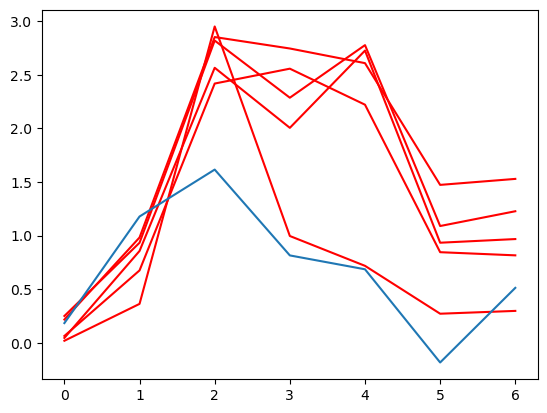

In [15]:
dataset = P53Data(replicate=0, data_dir='../data/')
ground_truth = P53Data.params_ground_truth()


for i in range(5):
    plt.plot(dataset.m_observed[0, i], color='red')
plt.plot(dataset.f_observed[0, 0])

In [19]:
# Kernel definition

import gpytorch
import torch
import numpy as np

from gpytorch.constraints import Positive, Interval

PI = torch.tensor(np.pi, requires_grad=False)


class SIMKernel(gpytorch.kernels.Kernel):
    """
    Simple Input Module Motif Kernel
    This kernel is the multi-output cross-kernel for linear response to single transcription factor.
    In other words, it constructs a JTxJT matrix where J is num genes and T is num timepoints.
    SIM: Single Input Module motif
    """

    is_stationary = True

    def __init__(self, num_genes, variance, dtype=torch.float32, **kwargs):
        super().__init__(**kwargs)
        self.num_genes = num_genes
        self.pos_constraint = Positive()
        self.lengthscale_constraint = Interval(0.5, 3.5)

        self.register_parameter(
            name='raw_lengthscale', parameter=torch.nn.Parameter(
                self.lengthscale_constraint.inverse_transform(2.5 * torch.ones(1, 1, dtype=dtype)))
        )
        self.register_parameter(
            name='raw_decay', parameter=torch.nn.Parameter(
                self.pos_constraint.inverse_transform(0.4 * torch.ones(self.num_genes, dtype=dtype)))
        )
        self.register_parameter(
            name='raw_sensitivity', parameter=torch.nn.Parameter(
                self.pos_constraint.inverse_transform(1 * torch.ones(self.num_genes, dtype=dtype)))
        )
        self.register_parameter(
            name='raw_noise', parameter=torch.nn.Parameter(1 * torch.ones(self.num_genes, dtype=dtype))
        )

        # register the constraints
        self.register_constraint("raw_lengthscale", self.lengthscale_constraint)
        self.register_constraint("raw_sensitivity", Positive())
        self.register_constraint("raw_decay", Positive())
        self.register_constraint("raw_noise", self.pos_constraint)

        self.variance = torch.diag(variance)

    @property
    def lengthscale(self):
        return self.lengthscale_constraint.transform(self.raw_lengthscale)

    @lengthscale.setter
    def lengthscale(self, value):
        self.initialize(raw_lengthscale=self.lengthscale_constraint.inverse_transform(value))

    @property
    def decay(self):
        return self.pos_constraint.transform(self.raw_decay)

    @decay.setter
    def decay(self, value):
        self.initialize(raw_decay=self.pos_constraint.inverse_transform(value))

    @property
    def sensitivity(self):
        return self.pos_constraint.transform(self.raw_sensitivity)

    @sensitivity.setter
    def sensitivity(self, value):
        self.initialize(raw_sensitivity=self.pos_constraint.inverse_transform(value))

    @property
    def noise(self):
        return self.pos_constraint.transform(self.raw_noise)

    @noise.setter
    def noise(self, value):
        self.initialize(raw_noise=self.pos_constraint.inverse_transform(value))

    def plot_cov(self, x1, x2):
        from matplotlib import pyplot as plt
        Kxx = self(x1, x2)
        plt.figure()
        plt.imshow(Kxx.detach().evaluate().detach())
        plt.colorbar()
        return Kxx

    def forward(self, t1, t2, **params):
        """
        This calculates Kxx (not cross-covariance)
        t1, t2 are blocked timepoint vectors
        Parameters:
           x1 shape (num_genes*num_times)
        """
        vert_block_size = int(t1.shape[0] / self.num_genes)
        hori_block_size = int(t2.shape[0] / self.num_genes)
        t1_block, t2_block = t1[:vert_block_size], t2[:hori_block_size]
        shape = [vert_block_size * self.num_genes, hori_block_size * self.num_genes]
        K_xx = torch.zeros(shape, dtype=torch.float64)
        for j in range(self.num_genes):
            for k in range(self.num_genes):
                kxx = self.k_xx(j, k, t1_block, t2_block)
                K_xx[j * vert_block_size:(j + 1) * vert_block_size,
                     k * hori_block_size:(k + 1) * hori_block_size] = kxx

        if hori_block_size == vert_block_size:
            # noise = self.noise.view(-1, 1).repeat(1, hori_block_size).view(-1)
            # noise = torch.diag(noise)
            jitter = 1e-4 * torch.eye(K_xx.shape[0], dtype=torch.float64)
            K_xx += jitter
            if K_xx.shape[0] == self.variance.shape[0]:
                K_xx += self.variance
        return K_xx

    def k_xx(self, j, k, t1_block, t2_block):
        """
        k_xx(t, t')
        t2 = t'
        Parameters:
            t1_block: tensor shape (T1,)
            t2_block: tensor shape (T2,)
        """
        t1_block = t1_block.view(-1, 1)
        t2_block = t2_block.view(1, -1)
        mult = self.sensitivity[j] * self.sensitivity[k] * self.lengthscale * 0.5 * torch.sqrt(PI)
        k_xx = mult * (self.h(k, j, t2_block, t1_block) + self.h(j, k, t1_block, t2_block))
        return k_xx

    def h(self, k, j, t2, t1):
        l = self.lengthscale
        t_dist = t2 - t1
        multiplier = torch.exp(self.gamma(k) ** 2) / (self.decay[j] + self.decay[k])  # (1, 1)
        first_erf_term = torch.erf(t_dist / l - self.gamma(k)) + torch.erf(t1 / l + self.gamma(k))  # (T,T)
        second_erf_term = torch.erf(t2 / l - self.gamma(k)) + torch.erf(self.gamma(k))
        return multiplier * (torch.multiply(torch.exp(-self.decay[k] * t_dist), first_erf_term) - \
                             torch.multiply(torch.exp(-self.decay[k] * t2 - self.decay[j] * t1), second_erf_term))

    def gamma(self, k):
        return self.decay[k] * self.lengthscale / 2

    def K_xf(self, x, f):
        """
        K_xf
        Cross-covariance. Not optimised (not in marginal likelihood).
        Parameters:
            x: tensor (JT, JT) the blocked observation vector
            f: tensor (T*) the non-blocked f prediction timepoint vector
        """
        shape = [x.shape[0], f.shape[0]]
        K_xf = torch.zeros(shape, dtype=torch.float32)
        self.block_size = int(x.shape[0] / self.num_genes)  # 7
        t1_block, t2_block = x[:self.block_size].view(-1, 1), f.view(1, -1)
        for j in range(self.num_genes):
            kxf = self.k_xf(j, t1_block, t2_block)
            K_xf[j * self.block_size:(j + 1) * self.block_size] = kxf

        return K_xf

    def k_xf(self, j, x, t_f):
        l = self.lengthscale
        t_dist = x - t_f
        erf_term = torch.erf(t_dist / l - self.gamma(j)) + torch.erf(t_f / l + self.gamma(j))
        return self.sensitivity[j] * l * 0.5 * torch.sqrt(PI) * torch.exp(self.gamma(j) ** 2) * torch.exp(
            -self.decay[j] * t_dist) * erf_term

    def K_ff(self, x1, x2):
        """Returns the RBF kernel between latent TF"""
        x1 = x1.view(-1)
        x2 = x2.view(-1)
        sq_dist = torch.square(x1.view(-1, 1)-x2)
        sq_dist = torch.div(sq_dist, 2*self.lengthscale.view((-1, 1)))
        K = torch.exp(-sq_dist)
        if K.shape[0] == K.shape[1]:
            jitter = 1e-3 * torch.eye(x1.shape[0])
            K += jitter
        return K

In [24]:
# Mean function definition
import gpytorch
import torch

from gpytorch.constraints import Positive


class SIMMean(gpytorch.means.Mean):

    def __init__(self, covar_module, num_genes, initial_basal):
        super().__init__()
        self.covar_module = covar_module
        self.pos_contraint = Positive()
        self.covar_module = covar_module
        self.num_genes = num_genes

        self.register_parameter(
            name='raw_basal', parameter=torch.nn.Parameter(
                self.pos_contraint.inverse_transform(0.05 * torch.ones(self.num_genes)))
        )
        self.register_constraint("raw_basal", self.pos_contraint)

        # self.basal = initial_basal

    @property
    def basal(self):
        return self.pos_contraint.transform(self.raw_basal)

    @basal.setter
    def basal(self, value):
        self.initialize(raw_basal=self.pos_contraint.inverse_transform(value))

    def forward(self, x):
        block_size = int(x.shape[0] / self.num_genes)
        m = (self.basal / self.covar_module.decay).view(-1, 1)
        m = m.repeat(1, block_size).view(-1)
        return m


In [25]:
# Models
import torch
import numpy as np
import gpytorch

from collections.abc import Iterable
from abc import abstractmethod
from typing import List
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import Subset
from torch.distributions import MultivariateNormal
from torch.nn import Module
from time import time
from pathlib import Path


class Trainer:
    """
    An abstract LFM trainer. Subclasses must implement the `single_epoch` function.

    Parameters
    ----------
    model: The Model.
    optimizers: list of `torch.optim.Optimizer`s. For when natural gradients are used for variational models.
    dataset: Dataset where t_observed (D, T), m_observed (J, T).
    batch_size:
    valid_size: int or float for number of training points or proportion of training points respectively
    test_size: int or float for number of or proportion of training points respectively
    track_parameters: the keys into `named_parameters()` of parameters that the trainer should track. The
                      tracked parameters can be accessed from `parameter_trace`
    train_mask: boolean mask
    """
    def __init__(self,
                 model: Module,
                 optimizers: List[torch.optim.Optimizer],
                 dataset,
                 batch_size=1,
                 valid_size=0.,
                 test_size=0.,
                 device_id=None,
                 track_parameters=None,
                 train_mask=None,
                 checkpoint_dir=None):
        self.model = model
        self.num_epochs = 0
        self.optimizers = optimizers
        self.dataset = dataset
        self.use_natural_gradient = len(self.optimizers) > 1
        self.batch_size = batch_size

        # Dataset splits
        dataset_size = len(dataset)
        if isinstance(valid_size, int):
            valid_size /= dataset_size
        if isinstance(test_size, int):
            test_size /= test_size
        indices = np.arange(dataset_size)
        np.random.shuffle(indices)
        valid_split = int(np.floor(valid_size * dataset_size))
        test_split = int(np.floor(test_size * dataset_size))
        # TODO this was added as a hack, for unknown reasons
        duplicate = lambda ind: np.concatenate([ind, ind + dataset_size])
        # self.valid_indices = duplicate(indices[:valid_split])
        # self.test_indices = duplicate(indices[valid_split:test_split + valid_split])
        # self.train_indices = duplicate(indices[test_split + valid_split:])
        self.valid_indices = indices[:valid_split]
        self.test_indices = indices[valid_split:test_split + valid_split]
        self.train_indices = indices[test_split + valid_split:]
        self.data_loader = self.test_loader = self.valid_loader = None
        self.set_loaders()

        self.losses = None
        self.train_mask = train_mask
        self.checkpoint_dir = checkpoint_dir
        self.parameter_trace = None
        self.device_id = device_id

        if track_parameters is not None:
            named_params = dict(model.named_parameters())
            self.parameter_trace = {key: [named_params[key].detach()] for key in track_parameters}

    def set_loaders(self):
        valid_data = Subset(self.dataset, self.valid_indices)
        test_data = Subset(self.dataset, self.test_indices)
        train_data = Subset(self.dataset, self.train_indices)
        self.test_loader = DataLoader(test_data, batch_size=self.batch_size, shuffle=False)
        self.valid_loader = DataLoader(valid_data, batch_size=self.batch_size, shuffle=False)
        self.data_loader = DataLoader(train_data, batch_size=self.batch_size, shuffle=False)

    def train(self, epochs=20, report_interval=1, reporter_callback=None, **kwargs):
        """
        Parameters:
            epochs: the number of training epochs to run
            report_interval: every report_interval epochs, a progress string will be printed
            reporter_callback: function called every report_interval
        """
        self.model.train()

        losses = list()
        times = list()
        end_epoch = self.num_epochs+epochs

        for epoch in range(epochs):
            epoch_loss = self.single_epoch(epoch=self.num_epochs, **kwargs)
            t = time()
            times.append((t, epoch_loss))

            if isinstance(epoch_loss, Iterable):
                epoch_loss, loss_breakdown = epoch_loss
            else:
                loss_breakdown = [epoch_loss]

            if (epoch % report_interval) == 0:
                if reporter_callback is not None:
                    reporter_callback(self.num_epochs)
                print('Epoch %03d/%03d - Loss: %.2f ' % (
                    self.num_epochs + 1, end_epoch, epoch_loss), end='')
                if len(loss_breakdown) > 1:
                    print(' '.join(map(lambda l: '%.2f' % l, loss_breakdown[1:])), end='')

                self.print_extra()
                if self.checkpoint_dir is not None:
                    self.model.save(self.checkpoint_dir / f'epoch{epoch}')
            losses.append(loss_breakdown)

            self.after_epoch()
            self.num_epochs += 1

        losses = torch.tensor(losses).cpu().numpy()
        if self.losses is None:
            self.losses = np.empty((0, losses.shape[1]))
        self.losses = np.concatenate([self.losses, losses], axis=0)
        return times

    @abstractmethod
    def single_epoch(self, epoch=0, **kwargs):
        raise NotImplementedError

    def set_optimizers(self, optimizers):
        self.optimizers = optimizers

    def print_extra(self):
        print('')

    def after_epoch(self):
        if self.parameter_trace is not None:
            params = dict(self.model.named_parameters())
            for key in params:
                if key in self.parameter_trace:
                    self.parameter_trace[key].append(params[key].detach().clone())

    def save(self, folder_prefix='model', save_model=True, save_losses=True, save_optimizer=False, additional=None):
        """
        Save the model and trainer information.

        :param folder_prefix: the folder name containing the saved files will be folder_prefix-timestamp
        :param save_model:
        :param save_losses:
        :param save_optimizer:
        :param additional: object or list of objects to save alongside the default items.
        :return:
        """
        timestamp = int(time())
        path = Path(f'./{folder_prefix}-{timestamp}/')
        if path.exists():
            raise IOError('Path seems to already exist.')
        path.mkdir()

        torch.save((self.train_indices, self.test_indices, self.valid_indices), path / 'indices.pt')
        if save_model:
            torch.save(self.model.state_dict(), path / 'model.pt')

        if save_losses:
            torch.save(self.losses, path / 'losses.pt')

        if save_optimizer:
            for i, optimizer in enumerate(self.optimizers):
                torch.save(optimizer.state_dict(), path / 'optim[{i}].pt')

        if additional is not None:
            torch.save(additional, path / 'additional.pt')
        return timestamp

    def load(self, file_prefix='model', timestamp=''):
        """
        Loads optionally the model state dict, losses array, optimizer state dict, in that order.

        :param file_prefix:
        :param timestamp:
        """
        path = Path(f'./{file_prefix}-{timestamp}/')
        print('Loading from', path)
        if (path / 'indices.pt').exists():
            indices = torch.load(path / 'indices.pt')
            self.train_indices, self.test_indices, self.valid_indices = indices
            self.set_loaders()
        if (path / 'model.pt').exists():
            state_dict = torch.load(path / 'model.pt', map_location=torch.device('cpu'))
            self.model.load_state_dict(state_dict)
        if (path / 'losses.pt').exists():
            self.losses = torch.load(path / 'losses.pt')
        for i, optim in enumerate([f'optim[{i}].pt' for i in range(len(self.optimizers))]):
            if (path / optim).exists():
                self.optimizers[i].load_state_dict(torch.load(path / optim))

class Trainer(Trainer):
    def print_extra(self):
        if isinstance(self.model, gpytorch.models.GP):
            kernel = self.model.covar_module
            print(f'λ: {str(kernel.lengthscale.view(-1).detach().numpy())}', end='')
        elif hasattr(self.model, 'gp_model'):
            print(f'kernel: {self.model.summarise_gp_hyp()}', end='')
        super().print_extra()

class ExactTrainer(Trainer):
    def __init__(self, *args, loss_fn, **kwargs):
        super().__init__(*args, **kwargs)
        self.loss_fn = loss_fn
        self.losses = np.empty((0, 1))

    def single_epoch(self, **kwargs):
        epoch_loss = 0

        [optim.zero_grad() for optim in self.optimizers]
        # Output from model
        output = self.model(self.model.train_t)
        # print(output.mean.shape)
        # plt.imshow(output.covariance_matrix.detach())
        # plt.colorbar()
        # Calc loss and backprop gradients
        loss = -self.loss_fn(output, self.model.train_y.squeeze())
        loss.backward()
        [optim.step() for optim in self.optimizers]
        epoch_loss += loss.item()

        return epoch_loss, [epoch_loss]

    def print_extra(self):
        self.model.covar_module.lengthscale.item(),
        self.model.likelihood.noise.item()
        super().print_extra()


class LFM(Module):
    pass

class ExactLFM(LFM, gpytorch.models.ExactGP):
    """
    An implementation of the single input motif from Lawrence et al., 2006.
    """
    def __init__(self, dataset: LFMDataset, variance):
        train_t, train_y = flatten_dataset(dataset)
        super().__init__(train_t, train_y, likelihood=gpytorch.likelihoods.GaussianLikelihood())

        self.num_outputs = dataset.num_outputs
        self.train_t = train_t.view(-1, 1)
        self.train_y = train_y.view(-1, 1)
        self.covar_module = SIMKernel(self.num_outputs, torch.tensor(variance, requires_grad=False))
        initial_basal = torch.mean(train_y.view(self.num_outputs, -1), dim=1) * self.covar_module.decay
        self.mean_module = SIMMean(self.covar_module, self.num_outputs, initial_basal)

    @property
    def decay_rate(self):
        return self.covar_module.decay

    @decay_rate.setter
    def decay_rate(self, val):
        self.covar_module.decay = val

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

    def predict_m(self, pred_t, jitter=1e-5) -> torch.distributions.MultivariateNormal:
        """
        Predict outputs of the LFM
        :param pred_t: prediction times
        :param jitter:
        :return:
        """
        Kxx = self.covar_module(self.train_t, self.train_t)
        K_inv = torch.inverse(Kxx.evaluate())
        pred_t_blocked = pred_t.repeat(self.num_outputs)
        K_xxstar = self.covar_module(self.train_t, pred_t_blocked).evaluate()
        K_xstarx = torch.transpose(K_xxstar, 0, 1).type(torch.float64)
        K_xstarxK_inv = torch.matmul(K_xstarx, K_inv)
        KxstarxKinvY = torch.matmul(K_xstarxK_inv, self.train_y)
        mean = KxstarxKinvY.view(self.num_outputs, pred_t.shape[0])

        K_xstarxstar = self.covar_module(pred_t_blocked, pred_t_blocked).evaluate()
        var = K_xstarxstar - torch.matmul(K_xstarxK_inv, torch.transpose(K_xstarx, 0, 1))
        var = torch.diagonal(var, dim1=0, dim2=1).view(self.num_outputs, pred_t.shape[0])
        mean = mean.transpose(0, 1)
        var = var.transpose(0, 1)
        var = torch.diag_embed(var)
        var += jitter * torch.eye(var.shape[-1])
        return MultivariateNormal(mean, var)

    def predict_f(self, pred_t, jitter=1e-3) -> MultivariateNormal:
        """
        Predict the latent function.

        :param pred_t: Prediction times
        :param jitter:
        :return:
        """
        Kxx = self.covar_module(self.train_t, self.train_t)
        K_inv = torch.inverse(Kxx.evaluate())

        Kxf = self.covar_module.K_xf(self.train_t, pred_t).type(torch.float64)
        KfxKxx = torch.matmul(torch.transpose(Kxf, 0, 1), K_inv)
        mean = torch.matmul(KfxKxx, self.train_y).view(-1).unsqueeze(0)

        #Kff-KfxKxxKxf
        Kff = self.covar_module.K_ff(pred_t, pred_t)  # (100, 500)
        var = Kff - torch.matmul(KfxKxx, Kxf)
        # var = torch.diagonal(var, dim1=0, dim2=1).view(-1)
        var = var.unsqueeze(0)
        # For some reason a full covariance is not PSD, for now just take the variance: (TODO)
        var = torch.diagonal(var, dim1=1, dim2=2)
        var = torch.diag_embed(var)
        var += jitter * torch.eye(var.shape[-1])

        batch_mvn = gpytorch.distributions.MultivariateNormal(mean, var)
        return gpytorch.distributions.MultitaskMultivariateNormal.from_batch_mvn(batch_mvn, task_dim=0)

    def save(self, filepath):
        torch.save(self.state_dict(), filepath+'lfm.pt')

    @classmethod
    def load(cls,
             filepath,
             lfm_args=[], lfm_kwargs={}):
        lfm_state_dict = torch.load(filepath+'lfm.pt')
        lfm = cls(*lfm_args, **lfm_kwargs)
        lfm.load_state_dict(lfm_state_dict)
        return lfm



def flatten_dataset(dataset):
    num_genes = dataset.num_outputs
    train_t = dataset[0][0]
    num_times = train_t.shape[0]
    m_observed = torch.stack([
        dataset[i][1] for i in range(num_genes)
    ]).view(num_genes, num_times)
    train_t = train_t.repeat(num_genes)
    train_y = m_observed.view(-1)
    return train_t, train_y

In [26]:
class ConstrainedTrainer(ExactTrainer):
    def after_epoch(self):
        super().after_epoch()
        with torch.no_grad():
            sens = self.lfm.covar_module.sensitivity
            sens[3] = np.float64(1.)
            deca = self.lfm.covar_module.decay
            deca[3] = np.float64(0.8)
            self.lfm.covar_module.sensitivity = sens
            self.lfm.covar_module.decay = deca

In [27]:
from gpytorch.mlls.exact_marginal_log_likelihood import ExactMarginalLogLikelihood

model = ExactLFM(dataset, dataset.variance.reshape(-1))

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = ExactMarginalLogLikelihood(model.likelihood, model)

track_parameters = [
    'mean_module.raw_basal',
    'covar_module.raw_decay',
    'covar_module.raw_sensitivity',
    'covar_module.raw_lengthscale',
]


trainer = ConstrainedTrainer(model, [optimizer], dataset, loss_fn=loss_fn, track_parameters=track_parameters)

In [28]:
model.likelihood.train()
a = trainer.train(epochs=150, report_interval=25)
a = np.array(a)

Epoch 001/150 - Loss: 1.20 λ: [2.4933224]


AttributeError: 'ConstrainedTrainer' object has no attribute 'lfm'